<a href="https://colab.research.google.com/github/rpdahxn/MakeYourFirstGANWithPyTorch/blob/main/13_cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [3]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

In [11]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [12]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # 이미지 목표(레이블)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 0-255의 이미지를 0-1로 정규화
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [13]:
mnist_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/mnist_data/mnist_train.csv')

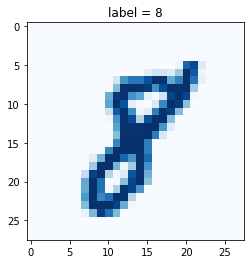

In [14]:
mnist_dataset.plot_image(17)

**신경망 클래스**

In [15]:
class Classifier(nn.Module):
    
    def __init__(self):
        # 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
        
            # 10 filters to 10 filters
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )
        
        # 손실함수 설정
        self.loss_function = nn.BCELoss()

        # 옵티마이저 설정
        self.optimiser = torch.optim.Adam(self.parameters())

        # 변수 초기화
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 신경망의 결과 계산
        outputs = self.forward(inputs)

        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기 초기화, 역전파 실행, 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

**신경망 훈련**

In [16]:
%%time

C = Classifier()

# MNIST 데이터셋에 대해 훈련

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 5min 29s, sys: 696 ms, total: 5min 30s
Wall time: 5min 35s


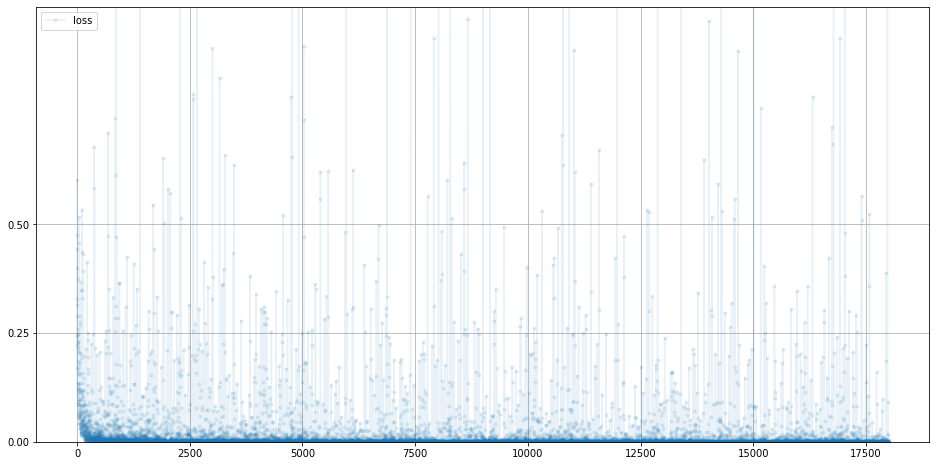

In [17]:
C.plot_progress()

In [18]:
# 분류기 예제

mnist_test_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/mnist_data/mnist_test.csv')

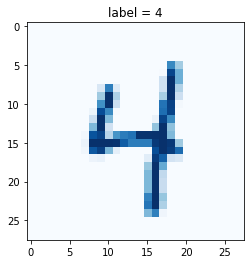

In [19]:
record = 19

mnist_test_dataset.plot_image(record)

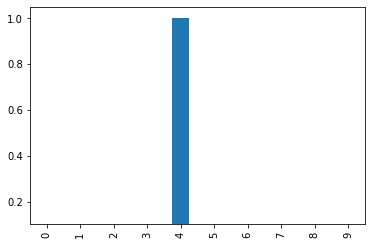

In [20]:
# 신경망이 예측한 답안 시각화
image_data = mnist_test_dataset[record][1]

# 훈련된 신경망으로부터 쿼리
output = C.forward(image_data.view(1, 1, 28, 28))

# 출력 텐서 플롯
pandas.DataFrame(output.detach().numpy()).plot(kind = 'bar', legend = False, ylim = (0.1))

**분류기 성능**

In [21]:
score = 0
items = 0

for label, image_date_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor.view(1, 1, 28, 28)).detach().numpy()
  if (answer.argmax() == label):
    score += 1
    pass
  items += 1

  pass

print(score, items, score/items)

974 10000 0.0974
